In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombia GeoJson'
geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#geojson

In [5]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.colums = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
status_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [6]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [10]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Casos activos VS Departamento (Estado)

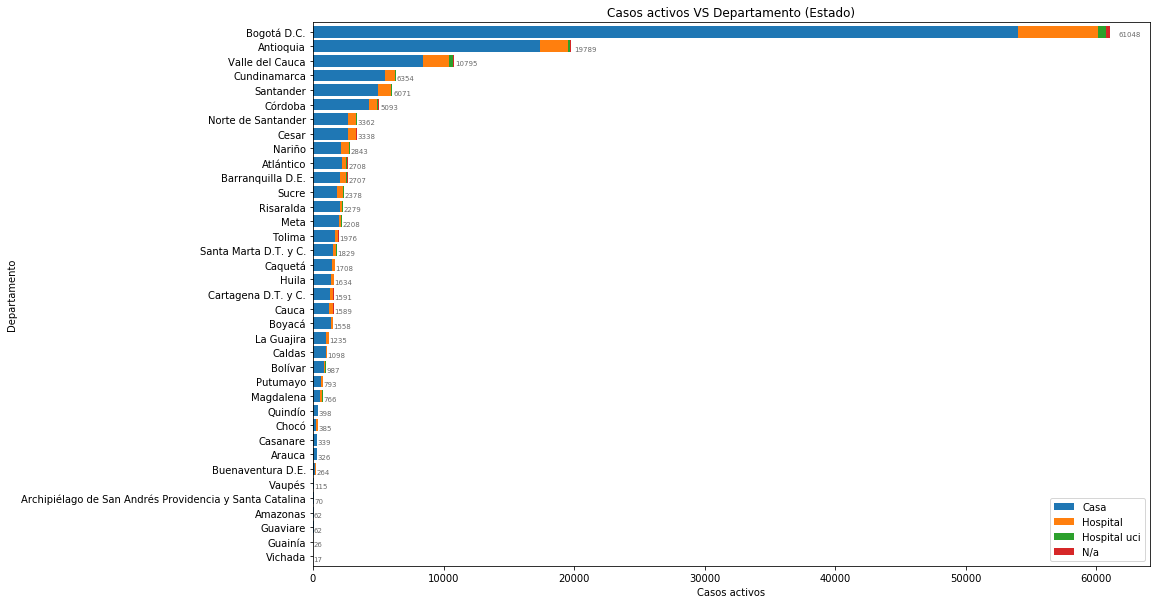

In [11]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
ax.set_facecolor('w')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [12]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         53988.0    6163.0   
Antioquia                                           17355.0    2148.0   
Valle del Cauca                                      8456.0    1944.0   
Cundinamarca                                         5540.0     761.0   
Santander                                            4988.0    1001.0   
Córdoba                                              4279.0     653.0   
Norte de Santander                                   2656.0     606.0   
Cesar                                                2718.0     558.0   
Nariño                                               2165.0     603.0   
Atlántico                                            2199.0     357.0   
Barranquilla D.E.                                    2061.0     497.0   
Sucre                                                1848.0     480.0   
Risaralda                                            2107.0     153.0   
Meta                                                 1991.0     190.0   
Tolima                                               1714.0     215.0   
Santa Marta D.T. y C.                                1554.0     246.0   
Caquetá                                              1446.0     239.0   
Huila                                                1387.0     229.0   
Cartagena D.T. y C.                                  1325.0     193.0   
Cauca                                                1201.0     323.0   
Boyacá                                               1388.0     142.0   
La Guajira                                            977.0     223.0   
Caldas                                                980.0      96.0   
Bolívar                                               818.0     126.0   
Putumayo                                              606.0     174.0   
Magdalena                                             522.0     184.0   
Quindío                                               363.0      31.0   
Chocó                                                 213.0     142.0   
Casanare                                              294.0      41.0   
Arauca                                                295.0      27.0   
Buenaventura D.E.                                     141.0      99.0   
Vaupés                                                110.0       5.0   
Archipiélago de San Andrés Providencia y Santa ...     57.0      12.0   
Amazonas                                               50.0       7.0   
Guaviare                                               57.0       4.0   
Guainía                                                26.0       0.0   
Vichada                                                15.0       2.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                608.0  289.0   
Antioquia                                                  200.0   86.0   
Valle del Cauca                                            296.0   99.0   
Cundinamarca                                                26.0   27.0   
Santander                                                   60.0   22.0   
Córdoba                                                     87.0   74.0   
Norte de Santander                                          86.0   14.0   
Cesar                                                       49.0   13.0   
Nariño                                                      48.0   27.0   
Atlántico                                                   65.0   87.0   
Barranquilla D.E.                                           53.0   96.0   
Sucre                                                       29.0   21.0   
Risaralda                                                   12.0    7.0   
Meta                       

### - Recuperados VS Departamento

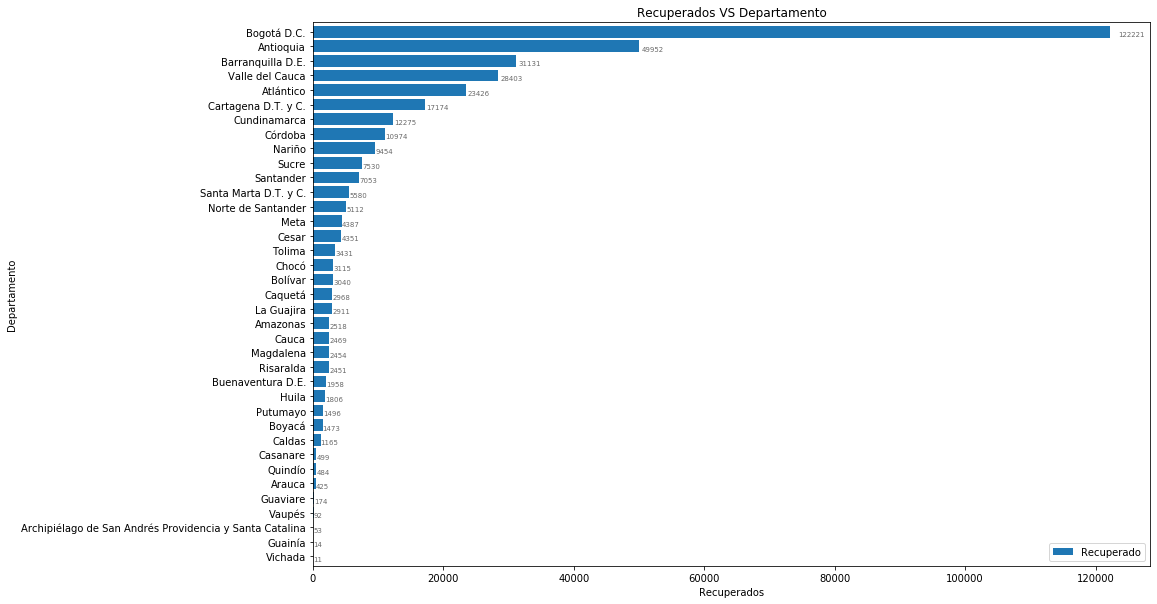

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, False, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Recuperados VS Departamento'))
ax.set_xlabel('Recuperados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                              Recuperado     Total
Departamento                                                            
Bogotá D.C.                                           122221.0  122221.0
Antioquia                                              49952.0   49952.0
Barranquilla D.E.                                      31131.0   31131.0
Valle del Cauca                                        28403.0   28403.0
Atlántico                                              23426.0   23426.0
Cartagena D.T. y C.                                    17174.0   17174.0
Cundinamarca                                           12275.0   12275.0
Córdoba                                                10974.0   10974.0
Nariño                                                  9454.0    9454.0
Sucre                                                   7530.0    7530.0
Santander                                               7053.0    7053.0
Santa Marta D.T. y C.                                   5580.0    5580.0
Norte de Santander                                      5112.0    5112.0
Meta                                                    4387.0    4387.0
Cesar                                                   4351.0    4351.0
Tolima                                                  3431.0    3431.0
Chocó                                                   3115.0    3115.0
Bolívar                                                 3040.0    3040.0
Caquetá                                                 2968.0    2968.0
La Guajira                                              2911.0    2911.0
Amazonas                                                2518.0    2518.0
Cauca                                                   2469.0    2469.0
Magdalena                                               2454.0    2454.0
Risaralda                                               2451.0    2451.0
Buenaventura D.E.                                       1958.0    1958.0
Huila                                                   1806.0    1806.0
Putumayo                                                1496.0    1496.0
Boyacá                                                  1473.0    1473.0
Caldas                                                  1165.0    1165.0
Casanare                                                 499.0     499.0
Quindío                                                  484.0     484.0
Arauca                                                   425.0     425.0
Guaviare                                                 174.0     174.0
Vaupés                                                    92.0      92.0
Archipiélago de San Andrés Providencia y Santa ...        53.0      53.0
Guainía                                                   14.0      14.0
Vichada                                                   11.0      11.0

### - Fallecidos VS Departamento

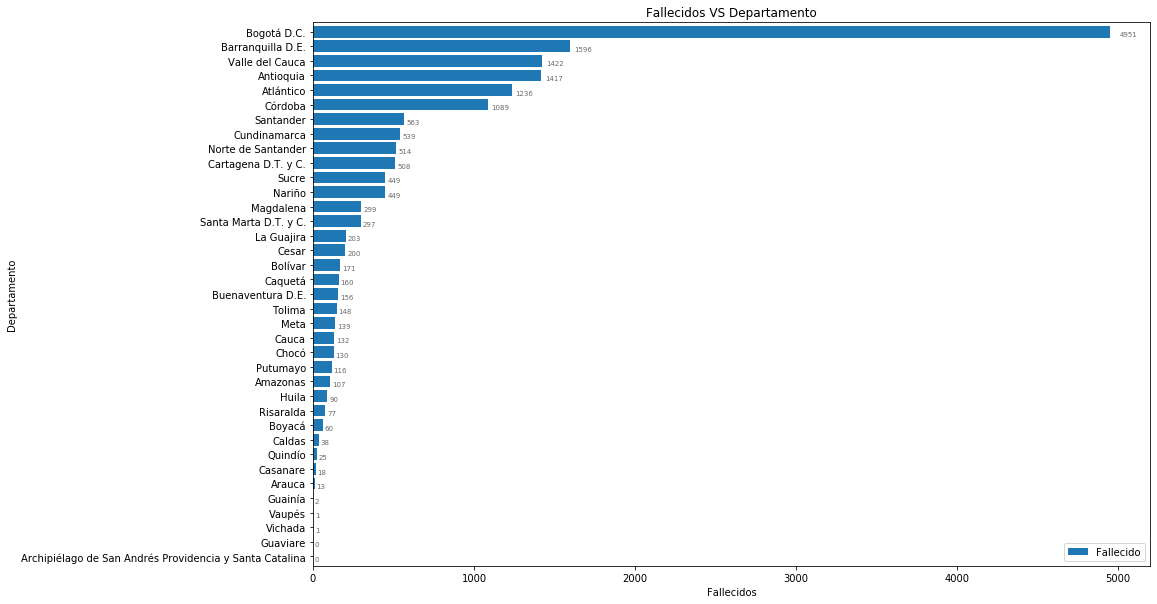

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Fallecidos VS Departamento'))
ax.set_xlabel('Fallecidos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [16]:
li.sort_values('Total', ascending=False)

Estado                                              Fallecido   Total
Departamento                                                         
Bogotá D.C.                                            4951.0  4951.0
Barranquilla D.E.                                      1596.0  1596.0
Valle del Cauca                                        1422.0  1422.0
Antioquia                                              1417.0  1417.0
Atlántico                                              1236.0  1236.0
Córdoba                                                1089.0  1089.0
Santander                                               563.0   563.0
Cundinamarca                                            539.0   539.0
Norte de Santander                                      514.0   514.0
Cartagena D.T. y C.                                     508.0   508.0
Sucre                                                   449.0   449.0
Nariño                                                  449.0   449.0
Magdalena                                               299.0   299.0
Santa Marta D.T. y C.                                   297.0   297.0
La Guajira                                              203.0   203.0
Cesar                                                   200.0   200.0
Bolívar                                                 171.0   171.0
Caquetá                                                 160.0   160.0
Buenaventura D.E.                                       156.0   156.0
Tolima                                                  148.0   148.0
Meta                                                    139.0   139.0
Cauca                                                   132.0   132.0
Chocó                                                   130.0   130.0
Putumayo                                                116.0   116.0
Amazonas                                                107.0   107.0
Huila                                                    90.0    90.0
Risaralda                                                77.0    77.0
Boyacá                                                   60.0    60.0
Caldas                                                   38.0    38.0
Quindío                                                  25.0    25.0
Casanare                                                 18.0    18.0
Arauca                                                   13.0    13.0
Guainía                                                   2.0     2.0
Vaupés                                                    1.0     1.0
Vichada                                                   1.0     1.0
Guaviare                                                  0.0     0.0
Archipiélago de San Andrés Providencia y Santa ...        0.0     0.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

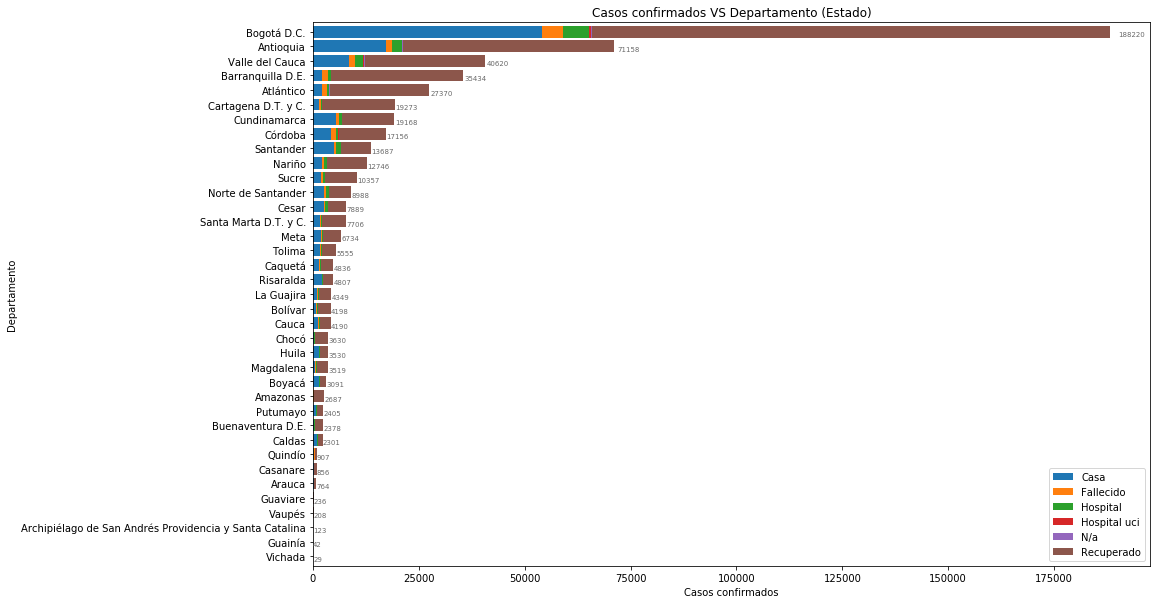

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         53988.0     4951.0   
Antioquia                                           17355.0     1417.0   
Valle del Cauca                                      8456.0     1422.0   
Barranquilla D.E.                                    2061.0     1596.0   
Atlántico                                            2199.0     1236.0   
Cartagena D.T. y C.                                  1325.0      508.0   
Cundinamarca                                         5540.0      539.0   
Córdoba                                              4279.0     1089.0   
Santander                                            4988.0      563.0   
Nariño                                               2165.0      449.0   
Sucre                                                1848.0      449.0   
Norte de Santander                                   2656.0      514.0   
Cesar                                                2718.0      200.0   
Santa Marta D.T. y C.                                1554.0      297.0   
Meta                                                 1991.0      139.0   
Tolima                                               1714.0      148.0   
Caquetá                                              1446.0      160.0   
Risaralda                                            2107.0       77.0   
La Guajira                                            977.0      203.0   
Bolívar                                               818.0      171.0   
Cauca                                                1201.0      132.0   
Chocó                                                 213.0      130.0   
Huila                                                1387.0       90.0   
Magdalena                                             522.0      299.0   
Boyacá                                               1388.0       60.0   
Amazonas                                               50.0      107.0   
Putumayo                                              606.0      116.0   
Buenaventura D.E.                                     141.0      156.0   
Caldas                                                980.0       38.0   
Quindío                                               363.0       25.0   
Casanare                                              294.0       18.0   
Arauca                                                295.0       13.0   
Guaviare                                               57.0        0.0   
Vaupés                                                110.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...     57.0        0.0   
Guainía                                                26.0        2.0   
Vichada                                                15.0        1.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6163.0         608.0   
Antioquia                                             2148.0         200.0   
Valle del Cauca                                       1944.0         296.0   
Barranquilla D.E.                                      497.0          53.0   
Atlántico                                              357.0          65.0   
Cartagena D.T. y C.                                    193.0          41.0   
Cundinamarca                                           761.0          26.0   
Córdoba                                                653.0          87.0   
Santander                                             1001.0          60.0   
Nariño                                                 603.0          48.0   
Sucre                                                  480.0          29.0   
Norte de Santander                                     606.0          86.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

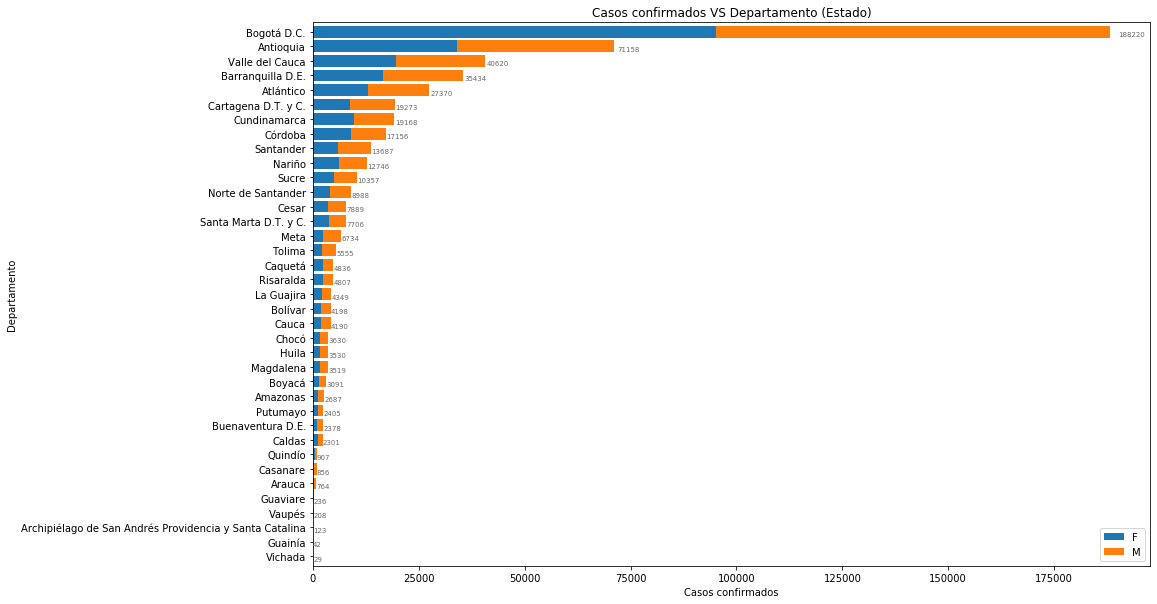

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                    F      M   Total
Departamento                                                            
Bogotá D.C.                                         95094  93126  188220
Antioquia                                           34039  37119   71158
Valle del Cauca                                     19604  21016   40620
Barranquilla D.E.                                   16650  18784   35434
Atlántico                                           12973  14397   27370
Cartagena D.T. y C.                                  8845  10428   19273
Cundinamarca                                         9693   9475   19168
Córdoba                                              8896   8260   17156
Santander                                            5837   7850   13687
Nariño                                               6104   6642   12746
Sucre                                                4974   5383   10357
Norte de Santander                                   4061   4927    8988
Cesar                                                3621   4268    7889
Santa Marta D.T. y C.                                3883   3823    7706
Meta                                                 2442   4292    6734
Tolima                                               2168   3387    5555
Caquetá                                              2399   2437    4836
Risaralda                                            2360   2447    4807
La Guajira                                           2189   2160    4349
Bolívar                                              1924   2274    4198
Cauca                                                1953   2237    4190
Chocó                                                1716   1914    3630
Huila                                                1759   1771    3530
Magdalena                                            1776   1743    3519
Boyacá                                               1440   1651    3091
Amazonas                                             1163   1524    2687
Putumayo                                             1084   1321    2405
Buenaventura D.E.                                     889   1489    2378
Caldas                                               1096   1205    2301
Quindío                                               447    460     907
Casanare                                              362    494     856
Arauca                                                233    531     764
Guaviare                                               35    201     236
Vaupés                                                 92    116     208
Archipiélago de San Andrés Providencia y Santa ...     69     54     123
Guainía                                                16     26      42
Vichada                                                 5     24      29

### - Dataset COVID-19 (Colombia)

In [21]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
541183               2020-08-23           2020-08-20            2020-08-09   
541184               2020-08-23           2020-08-20            2020-08-09   
541185               2020-08-23           2020-08-20            2020-08-09   
541186               2020-08-23           2020-08-20            2020-08-09   
541187               2020-08-23           2020-08-20            2020-08-09   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
541183             2020-08-05 00:00:00                   NaT   
541184             2020-08-05 00:00:00                   NaT   
541185             2020-08-05 00:00:00                   NaT   
541186             2020-08-05 00:00:00                   NaT   
541187             2020-08-05 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
541183                    NaT                Bello        Antioquia      Leve   
541184                    NaT             Rionegro        Antioquia      Leve   
541185                    NaT           Copacabana        Antioquia      Leve   
541186                    NaT             Apartadó        Antioquia      Leve   
541187                    NaT              La ceja        Antioquia      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
541183            Casa  ...                30 - 40    F               NaN   
541184            Casa  ...                30 - 40    F               NaN   
541185            Casa  ...                20 - 30    F               NaN   
541186            Casa  ...                40 - 50    F               NaN   
541187            Casa  ...                 0 - 10    M               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Mapa de influencia COVID-19 (Colombia)

In [22]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

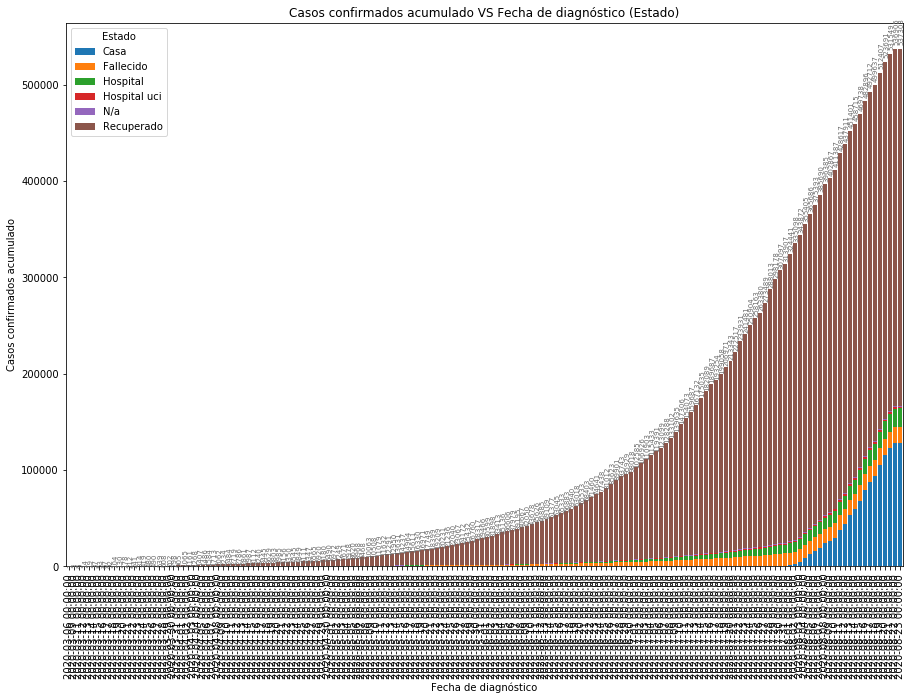

In [23]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [24]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-08-23            127875.0    17114.0   18788.0        1930.0  1070.0   
2020-08-22            127495.0    17114.0   18770.0        1930.0  1070.0   
2020-08-21            122601.0    17107.0   18337.0        1912.0  1070.0   
2020-08-20            115491.0    17027.0   17817.0        1900.0  1065.0   
2020-08-19            105444.0    16862.0   17050.0        1863.0  1057.0   
2020-08-18             94066.0    16724.0   16463.0        1854.0  1047.0   
2020-08-17             87910.0    16587.0   16046.0        1851.0  1038.0   
2020-08-16             79323.0    16486.0   15684.0        1848.0  1033.0   
2020-08-15             68260.0    16299.0   15204.0        1846.0  1028.0   
2020-08-14             59229.0    16099.0   14710.0        1832.0  1022.0   
2020-08-13             53247.0    15926.0   14372.0        1821.0  1015.0   
2020-08-12             43539.0    15698.0   13846.0        1800.0  1003.0   
2020-08-11             38191.0    15437.0   13331.0        1777.0   994.0   
2020-08-10             29512.0    15112.0   12632.0        1718.0   979.0   
2020-08-09             26147.0    14935.0   12273.0        1700.0   964.0   
2020-08-08             23712.0    14740.0   11948.0        1676.0   960.0   
2020-08-07             19509.0    14470.0   11635.0        1639.0   949.0   
2020-08-06             15808.0    14227.0   11289.0        1586.0   934.0   
2020-08-05             12613.0    13978.0   10979.0        1536.0   915.0   
2020-08-04              8814.0    13727.0   10618.0        1487.0   897.0   
2020-08-03              4420.0    13436.0   10286.0        1438.0   882.0   
2020-08-02              2211.0    13133.0    9894.0        1397.0   866.0   
2020-08-01              1429.0    12794.0    9491.0        1354.0   852.0   
2020-07-31               830.0    12474.0    9040.0        1316.0   833.0   
2020-07-30               603.0    12257.0    8800.0        1293.0   818.0   
2020-07-29               304.0    11982.0    8528.0        1247.0   804.0   
2020-07-28               189.0    11712.0    8207.0        1197.0   784.0   
2020-07-27               178.0    11189.0    7691.0        1138.0   750.0   
2020-07-26               172.0    10881.0    7403.0        1100.0   731.0   
2020-07-25               171.0    10650.0    7213.0        1074.0   721.0   
2020-07-24               155.0    10354.0    6902.0        1035.0   709.0   
2020-07-23               139.0    10065.0    6592.0         997.0   689.0   
2020-07-22               124.0     9702.0    6245.0         958.0   661.0   
2020-07-21                84.0     9267.0    5817.0         903.0   637.0   
2020-07-20                62.0     8927.0    5530.0         850.0   624.0   
2020-07-19                60.0     8661.0    5209.0         817.0   613.0   
2020-07-18                56.0     8386.0    4942.0         792.0   596.0   
2020-07-17                55.0     8149.0    4761.0         762.0   575.0   
2020-07-16                54.0     7979.0    4652.0         746.0   567.0   
2020-07-15                52.0     7700.0    4393.0         709.0   548.0   
2020-07-14                49.0     7408.0    4175.0         674.0   539.0   
2020-07-13                46.0     7124.0    3941.0         645.0   517.0   
2020-07-12                40.0     6858.0    3691.0         612.0   496.0   
2020-07-11                39.0     6647.0    3535.0         583.0   482.0   
2020-07-10                38.0     6388.0    3323.0         564.0   455.0   
2020-07-09                38.0     6169.0    3124.0         535.0   438.0   
2020-07-08                33.0     5876.0    2874.0         492.0   429.0   
2020-07-07                33.0     5636.0    2724.0         466.0   420.0   
2020-07-06                33.0     5424.0    2525.0         437.0   402.0   
2020-07-05                30.0     5293.0    2447.0         423.0   390.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

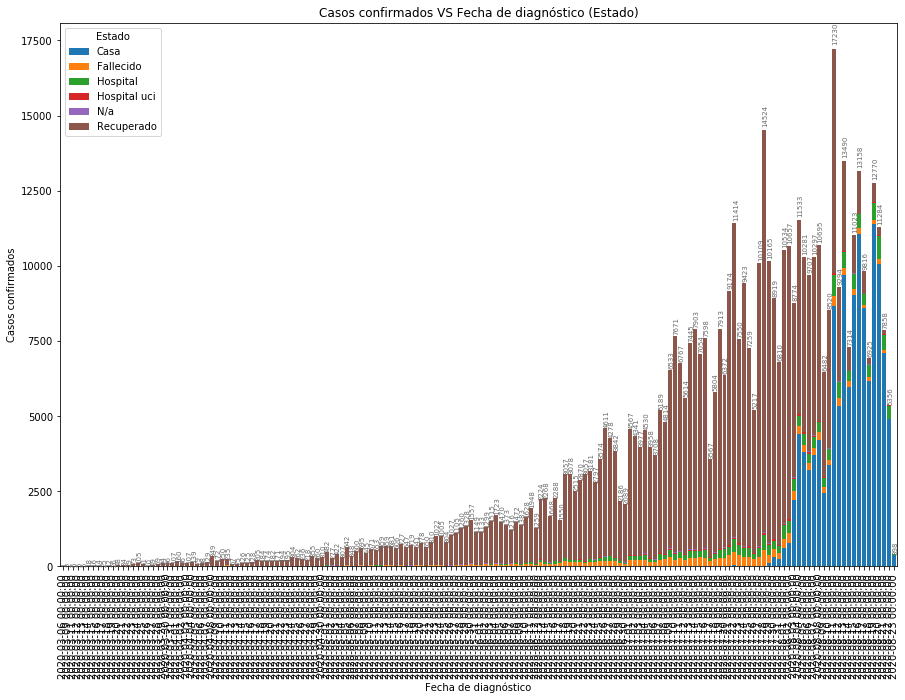

In [25]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [26]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                     
2020-08-23              380.0        0.0      18.0           0.0   0.0   
2020-08-22             4894.0        7.0     433.0          18.0   0.0   
2020-08-21             7110.0       80.0     520.0          12.0   5.0   
2020-08-20            10047.0      165.0     767.0          37.0   8.0   
2020-08-19            11378.0      138.0     587.0           9.0  10.0   
2020-08-18             6156.0      137.0     417.0           3.0   9.0   
2020-08-17             8587.0      101.0     362.0           3.0   5.0   
2020-08-16            11063.0      187.0     480.0           2.0   5.0   
2020-08-15             9031.0      200.0     494.0          14.0   6.0   
2020-08-14             5982.0      173.0     338.0          11.0   7.0   
2020-08-13             9708.0      228.0     526.0          21.0  12.0   
2020-08-12             5348.0      261.0     515.0          23.0   9.0   
2020-08-11             8679.0      325.0     699.0          59.0  15.0   
2020-08-10             3365.0      177.0     359.0          18.0  15.0   
2020-08-09             2435.0      195.0     325.0          24.0   4.0   
2020-08-08             4203.0      270.0     313.0          37.0  11.0   
2020-08-07             3701.0      243.0     346.0          53.0  15.0   
2020-08-06             3195.0      249.0     310.0          50.0  19.0   
2020-08-05             3799.0      251.0     361.0          49.0  18.0   
2020-08-04             4394.0      291.0     332.0          49.0  15.0   
2020-08-03             2209.0      303.0     392.0          41.0  16.0   
2020-08-02              782.0      339.0     403.0          43.0  14.0   
2020-08-01              599.0      320.0     451.0          38.0  19.0   
2020-07-31              227.0      217.0     240.0          23.0  15.0   
2020-07-30              299.0      275.0     272.0          46.0  14.0   
2020-07-29              115.0      270.0     321.0          50.0  20.0   
2020-07-28               11.0      523.0     516.0          59.0  34.0   
2020-07-27                6.0      308.0     288.0          38.0  19.0   
2020-07-26                1.0      231.0     190.0          26.0  10.0   
2020-07-25               16.0      296.0     311.0          39.0  12.0   
2020-07-24               16.0      289.0     310.0          38.0  20.0   
2020-07-23               15.0      363.0     347.0          39.0  28.0   
2020-07-22               40.0      435.0     428.0          55.0  24.0   
2020-07-21               22.0      340.0     287.0          53.0  13.0   
2020-07-20                2.0      266.0     321.0          33.0  11.0   
2020-07-19                4.0      275.0     267.0          25.0  17.0   
2020-07-18                1.0      237.0     181.0          30.0  21.0   
2020-07-17                1.0      170.0     109.0          16.0   8.0   
2020-07-16                2.0      279.0     259.0          37.0  19.0   
2020-07-15                3.0      292.0     218.0          35.0   9.0   
2020-07-14                3.0      284.0     234.0          29.0  22.0   
2020-07-13                6.0      266.0     250.0          33.0  21.0   
2020-07-12                1.0      211.0     156.0          29.0  14.0   
2020-07-11                1.0      259.0     212.0          19.0  27.0   
2020-07-10                0.0      219.0     199.0          29.0  17.0   
2020-07-09                5.0      293.0     250.0          43.0   9.0   
2020-07-08                0.0      240.0     150.0          26.0   9.0   
2020-07-07                0.0      212.0     199.0          29.0  18.0   
2020-07-06                3.0      131.0      78.0          14.0  12.0   
2020-07-05                3.0      150.0      97.0          17.0  15.0   
2020-07-04                1.0      193.0     188.0          26.0  19.0   
2020-07-03                3.0      198.0     128.0          12.0   9.0   
2020

### - Casos confirmados VS Clasificación de edad (Estado)

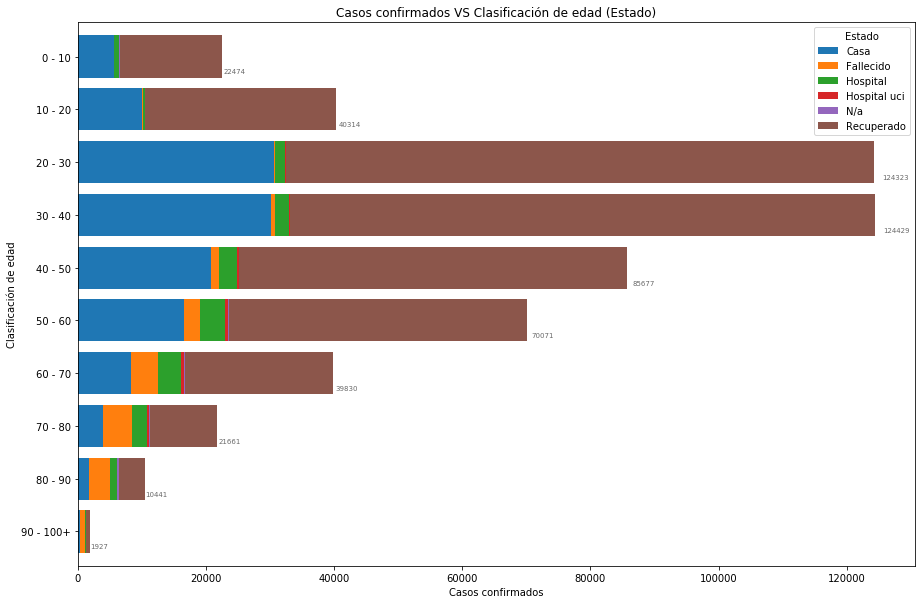

In [27]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [28]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  5580         30       816            53   26   
10 - 20                10051         27       411            33   20   
20 - 30                30601        223      1541            77   47   
30 - 40                30136        571      2234           183   39   
40 - 50                20809       1284      2740           285   86   
50 - 60                16490       2634      3849           482  133   
60 - 70                 8251       4196      3577           453  223   
70 - 80                 3968       4392      2387           284  253   
80 - 90                 1707       3223      1139            87  212   
90 - 100+                297        736       180             7   54   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      15969  
10 - 20                     29772  
20 - 30                     91834  
30 - 40                     91266  
40 - 50                     60473  
50 - 60                     46483  
60 - 70                     23130  
70 - 80                     10377  
80 - 90                      4073  
90 - 100+                     653

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

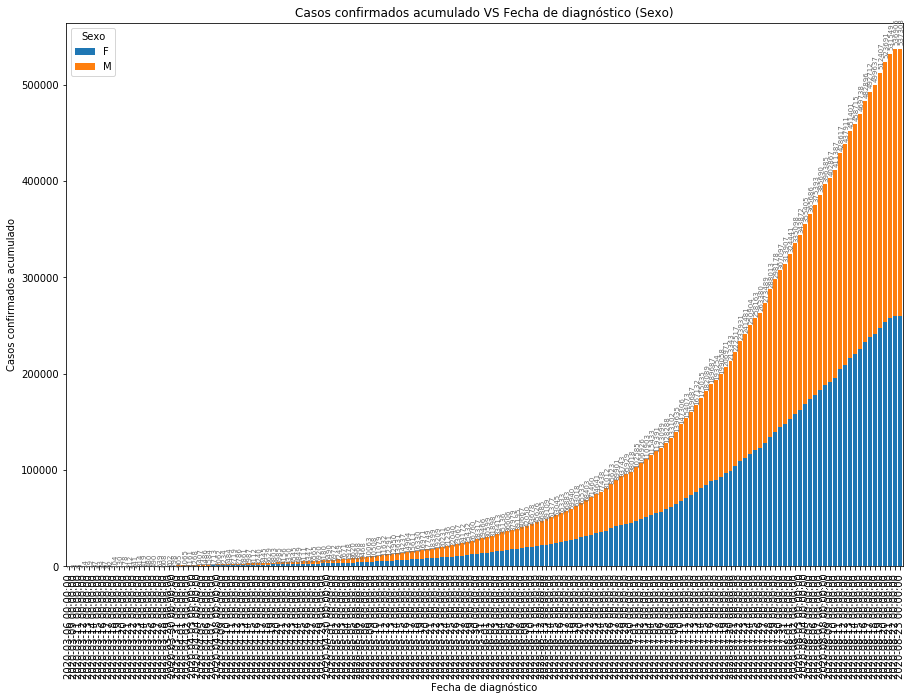

In [29]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [30]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-08-23            260073.0  277230.0
2020-08-22            259870.0  277035.0
2020-08-21            257362.0  274187.0
2020-08-20            253338.0  270353.0
2020-08-19            247636.0  264771.0
2020-08-18            241004.0  258633.0
2020-08-17            237645.0  255067.0
2020-08-16            232454.0  250442.0
2020-08-15            225568.0  244170.0
2020-08-14            219936.0  238779.0
2020-08-13            216191.0  235210.0
2020-08-12            209434.0  228477.0
2020-08-11            204835.0  223782.0
2020-08-10            195899.0  215488.0
2020-08-09            191625.0  211242.0
2020-08-08            188281.0  208104.0
2020-08-07            183070.0  202620.0
2020-08-06            178036.0  197357.0
2020-08-05            173231.0  192455.0
2020-08-04            168070.0  187335.0
2020-08-03            162293.0  181579.0
2020-08-02            158042.0  177056.0
2020-08-01            152590.0  171851.0
2020-07-31            147489.0  166418.0
2020-07-30            144065.0  163032.0
2020-07-29            139736.0  158442.0
2020-07-28            134690.0  153323.0
2020-07-27            127610.0  145879.0
2020-07-26            122763.0  140617.0
2020-07-25            120373.0  137790.0
2020-07-24            116701.0  134203.0
2020-07-23            112347.0  129134.0
2020-07-22            108778.0  125153.0
2020-07-21            103615.0  118902.0
2020-07-20             99317.0  114026.0
2020-07-19             96341.0  110630.0
2020-07-18             92551.0  106507.0
2020-07-17             89770.0  103484.0
2020-07-16             88013.0  101674.0
2020-07-15             84283.0   97806.0
2020-07-14             80937.0   94098.0
2020-07-13             77341.0   89791.0
2020-07-12             73773.0   85914.0
2020-07-11             71100.0   82973.0
2020-07-10             67886.0   79420.0
2020-07-09             64382.0   75253.0
2020-07-08             61417.0   71685.0
2020-07-07             59108.0   69180.0
2020-07-06             56699.0   66400.0
2020-07-05             54947.0   64444.0
2020-07-04             53113.0   62320.0
2020-07-03             51084.0   59819.0
2020-07-02             49228.0   57698.0
2020-07-01             47199.0   55386.0
2020-06-30             45124.0   52894.0
2020-06-29             44151.0   51778.0
2020-06-28             43151.0   50592.0
2020-06-27             41311.0   48590.0
2020-06-26             39314.0   46309.0
2020-06-25             37120.0   43892.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

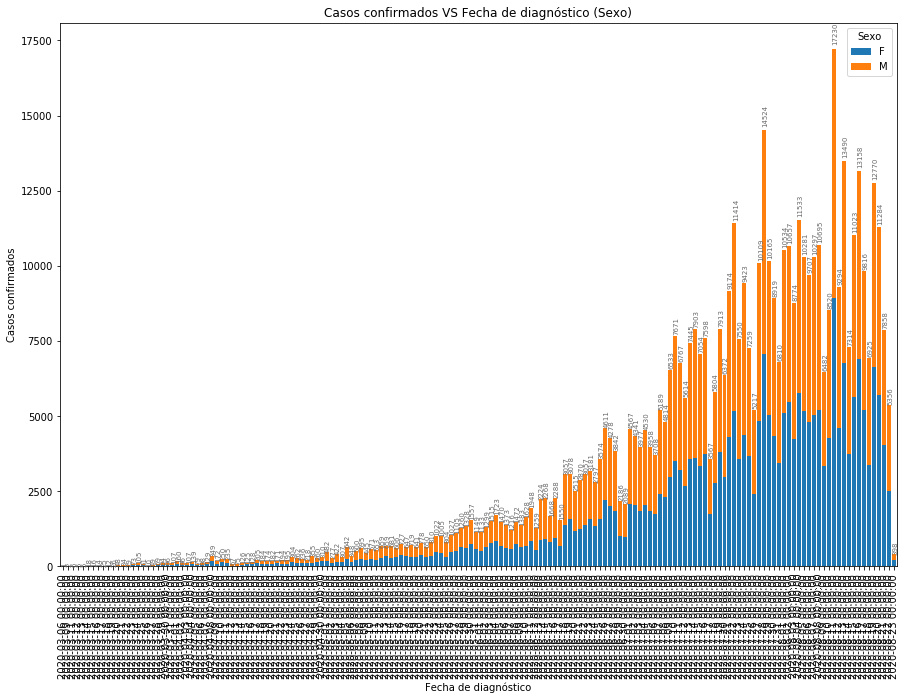

In [31]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [32]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-08-23             203.0   195.0
2020-08-22            2508.0  2848.0
2020-08-21            4024.0  3834.0
2020-08-20            5702.0  5582.0
2020-08-19            6632.0  6138.0
2020-08-18            3359.0  3566.0
2020-08-17            5191.0  4625.0
2020-08-16            6886.0  6272.0
2020-08-15            5632.0  5391.0
2020-08-14            3745.0  3569.0
2020-08-13            6757.0  6733.0
2020-08-12            4599.0  4695.0
2020-08-11            8936.0  8294.0
2020-08-10            4274.0  4246.0
2020-08-09            3344.0  3138.0
2020-08-08            5211.0  5484.0
2020-08-07            5034.0  5263.0
2020-08-06            4805.0  4902.0
2020-08-05            5161.0  5120.0
2020-08-04            5777.0  5756.0
2020-08-03            4251.0  4523.0
2020-08-02            5452.0  5205.0
2020-08-01            5101.0  5433.0
2020-07-31            3424.0  3386.0
2020-07-30            4329.0  4590.0
2020-07-29            5046.0  5119.0
2020-07-28            7080.0  7444.0
2020-07-27            4847.0  5262.0
2020-07-26            2390.0  2827.0
2020-07-25            3672.0  3587.0
2020-07-24            4354.0  5069.0
2020-07-23            3569.0  3981.0
2020-07-22            5163.0  6251.0
2020-07-21            4298.0  4876.0
2020-07-20            2976.0  3396.0
2020-07-19            3790.0  4123.0
2020-07-18            2781.0  3023.0
2020-07-17            1757.0  1810.0
2020-07-16            3730.0  3868.0
2020-07-15            3346.0  3708.0
2020-07-14            3596.0  4307.0
2020-07-13            3568.0  3877.0
2020-07-12            2673.0  2941.0
2020-07-11            3214.0  3553.0
2020-07-10            3504.0  4167.0
2020-07-09            2965.0  3568.0
2020-07-08            2309.0  2505.0
2020-07-07            2409.0  2780.0
2020-07-06            1752.0  1956.0
2020-07-05            1834.0  2124.0
2020-07-04            2029.0  2501.0
2020-07-03            1856.0  2121.0
2020-07-02            2029.0  2312.0
2020-07-01            2075.0  2492.0
2020-06-30             973.0  1116.0
2020-06-29            1000.0  1186.0
2020-06-28            1840.0  2002.0
2020-06-27            1997.0  2281.0
2020-06-26            2194.0  2417.0
2020-06-25            1570.0  2004.0

### - Casos confirmados VS Clasificación de edad (Sexo)

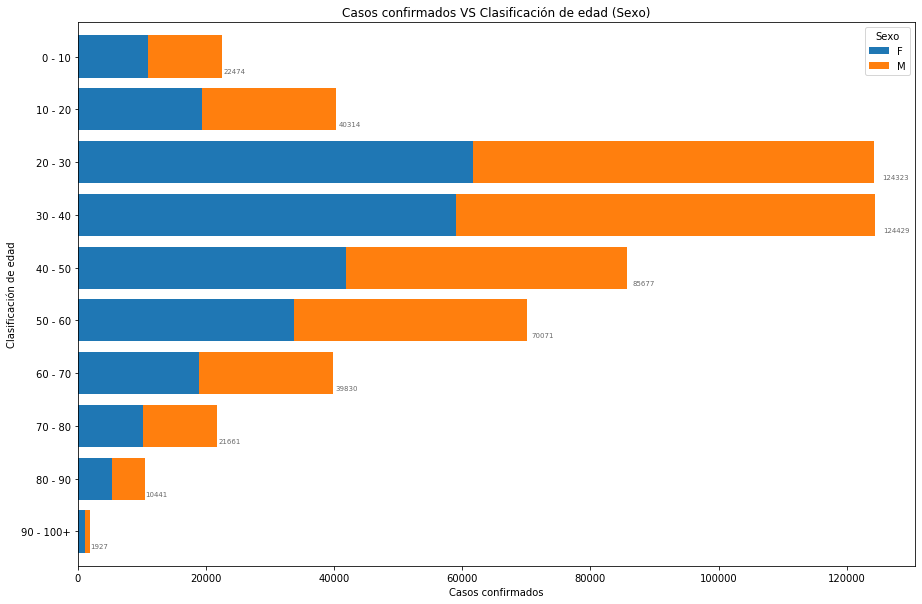

In [33]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [34]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 10974  11500
10 - 20                19303  21011
20 - 30                61607  62716
30 - 40                59084  65345
40 - 50                41768  43909
50 - 60                33787  36284
60 - 70                18865  20965
70 - 80                10090  11571
80 - 90                 5309   5132
90 - 100+               1104    823

### - Casos confirmados VS Estado (Sexo)

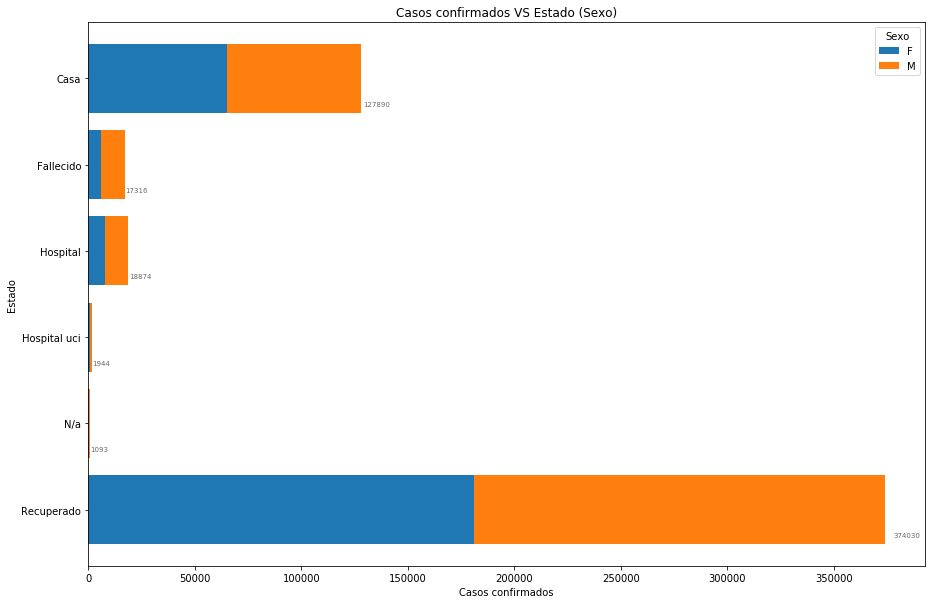

In [35]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [36]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           65328   62562
Fallecido       6203   11113
Hospital        8090   10784
Hospital uci     675    1269
N/a              471     622
Recuperado    181124  192906

### - Casos confirmados VS Tipo de contagio (Sexo)

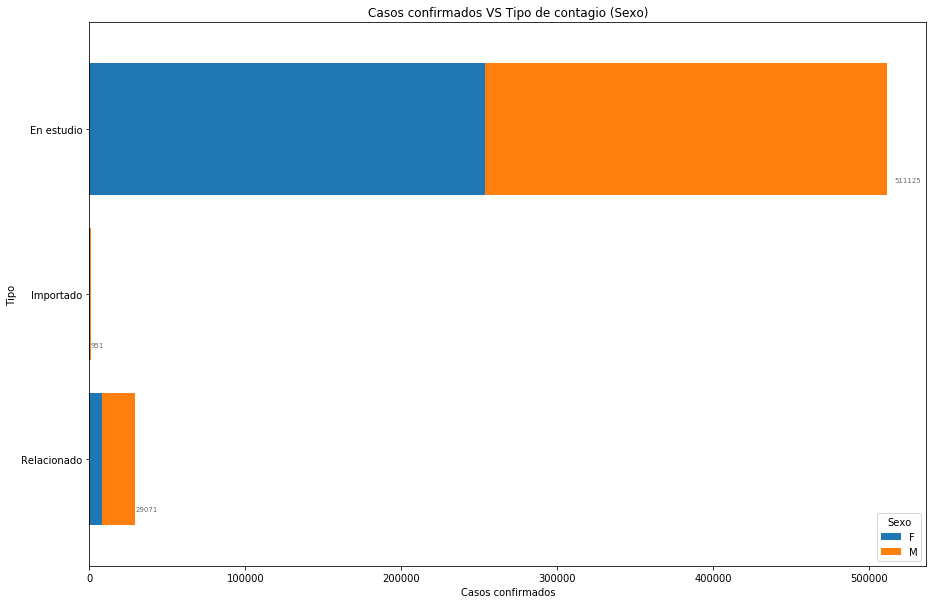

In [37]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [38]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   253459  257666
Importado       446     505
Relacionado    7986   21085

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

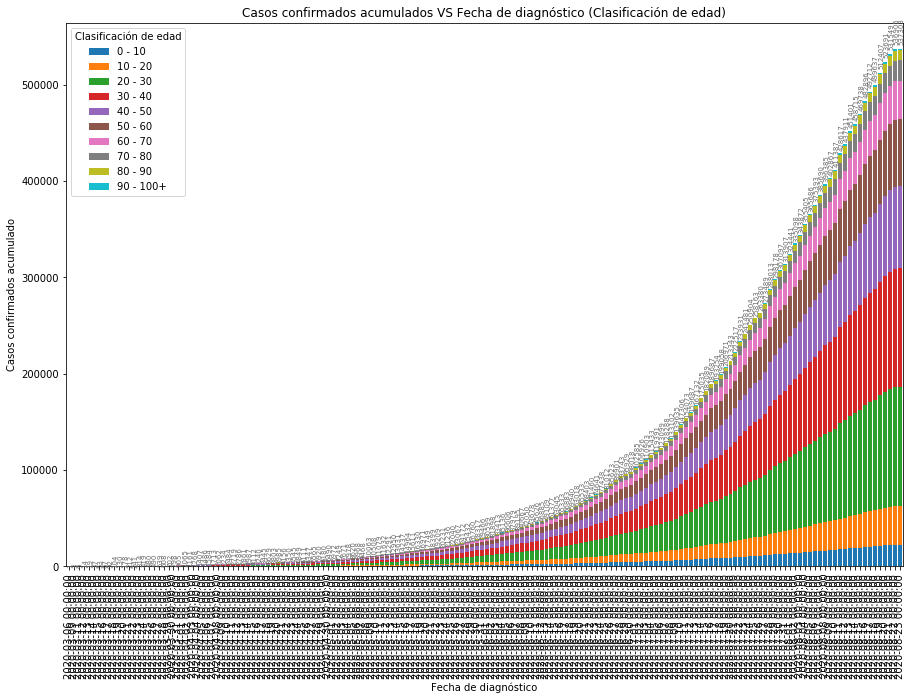

In [39]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [40]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-23              22339    40038   123412   123502    85112    69600   
2020-08-22              22332    40011   123305   123376    85044    69560   
2020-08-21              22138    39594   122080   122112    84242    68879   
2020-08-20              21819    39025   120211   120355    83000    67839   
2020-08-19              21360    38215   117743   117863    81234    66318   
2020-08-18              20749    37268   114887   115016    79151    64707   
2020-08-17              20511    36791   113375   113477    78059    63743   
2020-08-16              20000    36043   111201   111421    76493    62429   
2020-08-15              19388    34920   108271   108552    74398    60705   
2020-08-14              18892    34101   105761   106110    72666    59222   
2020-08-13              18642    33577   104091   104484    71487    58197   
2020-08-12              18026    32522   101056   101435    69331    56415   
2020-08-11              17688    31897    99023    99305    67851    55176   
2020-08-10              16902    30665    94972    95309    65041    52956   
2020-08-09              16576    29991    93050    93330    63707    51856   
2020-08-08              16336    29572    91553    91924    62634    50984   
2020-08-07              15922    28793    89137    89315    60954    49580   
2020-08-06              15508    28024    86782    86887    59318    48246   
2020-08-05              15061    27282    84627    84673    57766    46983   
2020-08-04              14635    26566    82271    82297    56103    45626   
2020-08-03              14148    25754    79621    79606    54211    44047   
2020-08-02              13825    25148    77634    77561    52874    42836   
2020-08-01              13383    24428    75226    75177    51073    41340   
2020-07-31              12971    23574    72675    72676    49457    40006   
2020-07-30              12698    23119    71154    71049    48295    39172   
2020-07-29              12355    22409    68986    68929    46981    38010   
2020-07-28              11975    21668    66570    66464    45303    36776   
2020-07-27              11348    20541    63254    63188    42993    34855   
2020-07-26              10962    19822    60874    60814    41332    33655   
2020-07-25              10751    19497    59686    59591    40523    32975   
2020-07-24              10468    19013    58052    57894    39360    31992   
2020-07-23              10147    18293    55852    55609    37888    30761   
2020-07-22               9870    17777    54169    53862    36687    29771   
2020-07-21               9464    16931    51447    51272    34903    28227   
2020-07-20               9103    16305    49284    49091    33423    27077   
2020-07-19               8825    15845    47929    47631    32355    26248   
2020-07-18               8512    15185    46095    45775    31045    25266   
2020-07-17               8290    14843    44801    44359    30088    24514   
2020-07-16               8167    14624    43999    43498    29541    24060   
2020-07-15               7825    14119    42293    41695    28296    23043   
2020-07-14               7532    13585    40696    40087    27171    22114   
2020-07-13               7236    13003    38828    38209    25895    21138   
2020-07-12               6981    12514    37046    36495    24681    20150   
2020-07-11               6740    12089    35736    35222    23767    19408   
2020-07-10               6489    11641    34106    33591    22682    18552   
2020-07-09               6204    11091    32251    31708    21524    17564   
2020-07-08               5984    10663    30697    30138    20484    16751   
2020-07-07               5794    10337    29605    28995    19714    16127   
2020-07-06               5594    10040    28377    27727    18825    15484   
2020-07-05            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

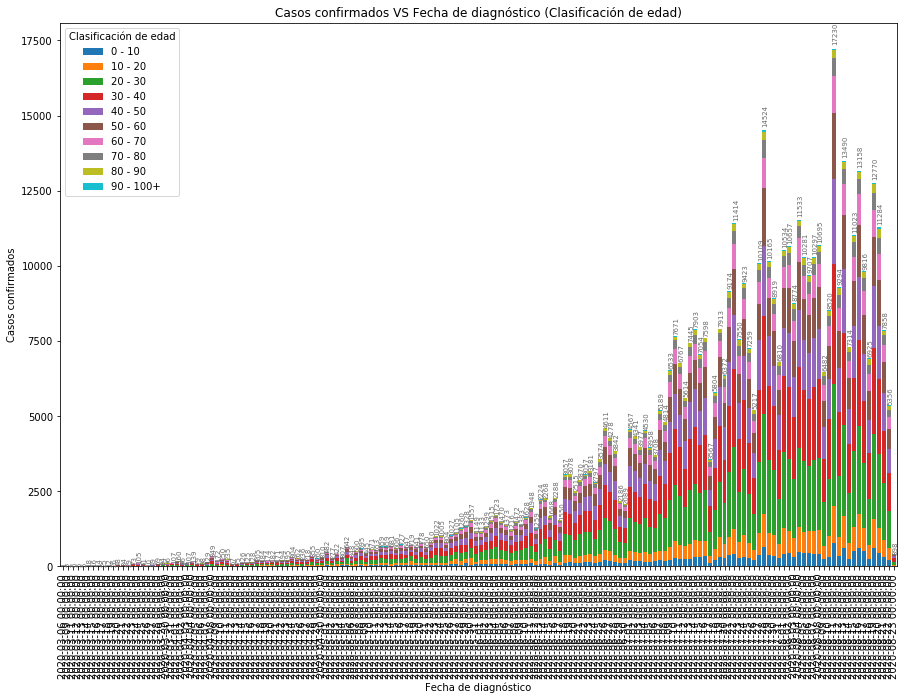

In [41]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [42]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-23                  7       27      107      126       68       40   
2020-08-22                194      417     1225     1264      802      681   
2020-08-21                319      569     1869     1757     1242     1040   
2020-08-20                459      810     2468     2492     1766     1521   
2020-08-19                611      947     2856     2847     2083     1611   
2020-08-18                238      477     1512     1539     1092      964   
2020-08-17                511      748     2174     2056     1566     1314   
2020-08-16                612     1123     2930     2869     2095     1724   
2020-08-15                496      819     2510     2442     1732     1483   
2020-08-14                250      524     1670     1626     1179     1025   
2020-08-13                616     1055     3035     3049     2156     1782   
2020-08-12                338      625     2033     2130     1480     1239   
2020-08-11                786     1232     4051     3996     2810     2220   
2020-08-10                326      674     1922     1979     1334     1100   
2020-08-09                240      419     1497     1406     1073      872   
2020-08-08                414      779     2416     2609     1680     1404   
2020-08-07                414      769     2355     2428     1636     1334   
2020-08-06                447      742     2155     2214     1552     1263   
2020-08-05                426      716     2356     2376     1663     1357   
2020-08-04                487      812     2650     2691     1892     1579   
2020-08-03                323      606     1987     2045     1337     1211   
2020-08-02                442      720     2408     2384     1801     1496   
2020-08-01                412      854     2551     2501     1616     1334   
2020-07-31                273      455     1521     1627     1162      834   
2020-07-30                343      710     2168     2120     1314     1162   
2020-07-29                380      741     2416     2465     1678     1234   
2020-07-28                627     1127     3316     3276     2310     1921   
2020-07-27                386      719     2380     2374     1661     1200   
2020-07-26                211      325     1188     1223      809      680   
2020-07-25                283      484     1634     1697     1163      983   
2020-07-24                321      720     2200     2285     1472     1231   
2020-07-23                277      516     1683     1747     1201      990   
2020-07-22                406      846     2722     2590     1784     1544   
2020-07-21                361      626     2163     2181     1480     1150   
2020-07-20                278      460     1355     1460     1068      829   
2020-07-19                313      660     1834     1856     1310      982   
2020-07-18                222      342     1294     1416      957      752   
2020-07-17                123      219      802      861      547      454   
2020-07-16                342      505     1706     1803     1245     1017   
2020-07-15                293      534     1597     1608     1125      929   
2020-07-14                296      582     1868     1878     1276      976   
2020-07-13                255      489     1782     1714     1214      988   
2020-07-12                241      425     1310     1273      914      742   
2020-07-11                251      448     1630     1631     1085      856   
2020-07-10                285      550     1855     1883     1158      988   
2020-07-09                220      428     1554     1570     1040      813   
2020-07-08                190      326     1092     1143      770      624   
2020-07-07                200      297     1228     1268      889      643   
2020-07-06                179      286      811      887      574      485   
2020-07-05            

### - Casos confirmados VS Estado (Clasificación de edad)

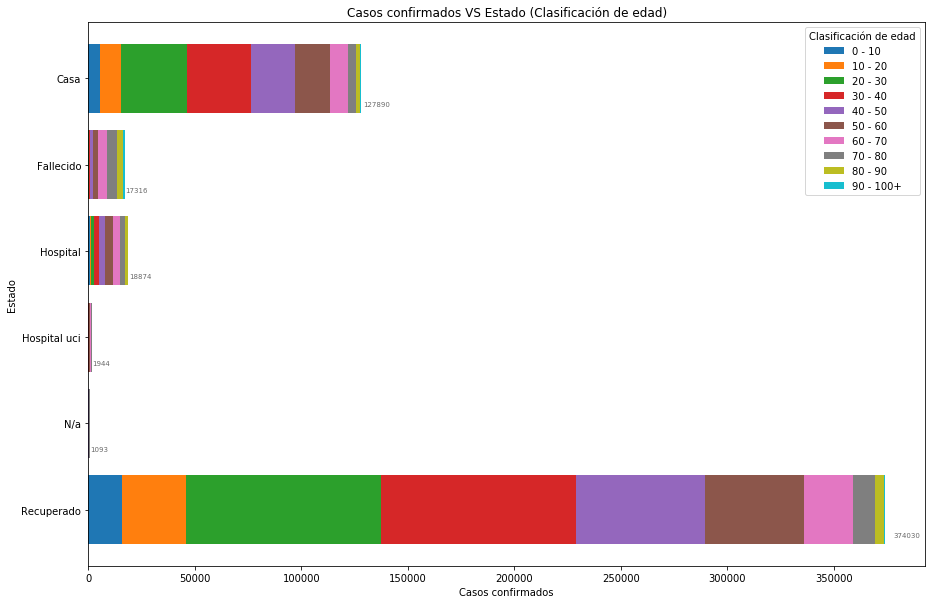

In [43]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [44]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     5580    10051    30601    30136    20809    16490   
Fallecido                  30       27      223      571     1284     2634   
Hospital                  816      411     1541     2234     2740     3849   
Hospital uci               53       33       77      183      285      482   
N/a                        26       20       47       39       86      133   
Recuperado              15969    29772    91834    91266    60473    46483   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      8251     3968     1707        297  
Fallecido                 4196     4392     3223        736  
Hospital                  3577     2387     1139        180  
Hospital uci               453      284       87          7  
N/a                        223      253      212         54  
Recuperado               23130    10377     4073        653

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

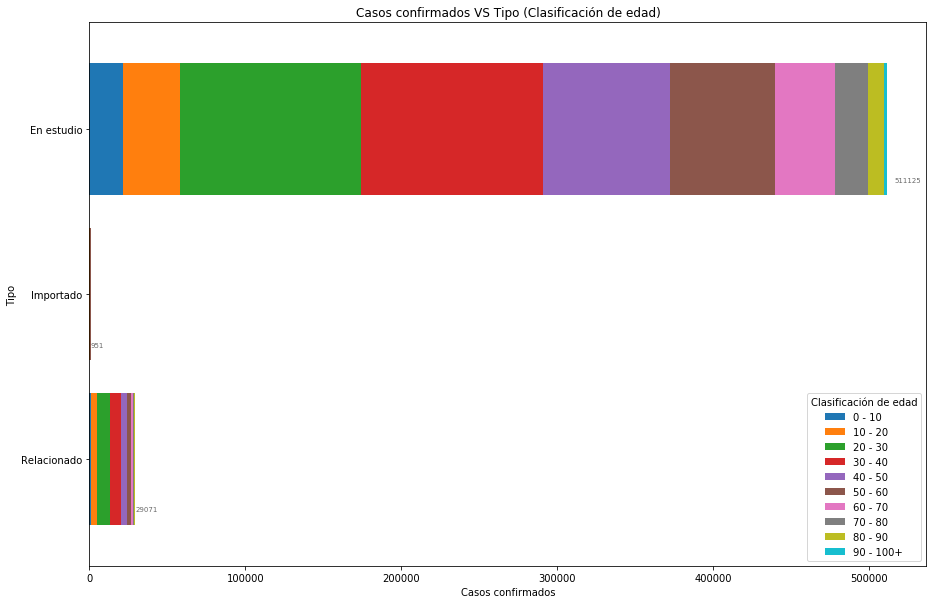

In [45]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [46]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              21484    36563   115836   116675    81813    67404   
Importado                   5       37      240      221      166      143   
Relacionado               985     3714     8247     7533     3698     2524   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               38424    21037    10057       1832  
Importado                   94       35        9          1  
Relacionado               1312      589      375         94

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>